# Import

In [71]:
import json
from tqdm import tqdm
import torch
from torch.optim import AdamW
from transformers import get_scheduler,AutoTokenizer, AutoModel
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd

In [72]:
import random

# Fixer la seed pour garantir la reproductibilité
seed = 42  # Choisissez une valeur fixe
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# Model

In [73]:
class GLiNER(nn.Module):
    def __init__(self, pretrained_model_name="microsoft/deberta-v3-base", span_max_length=2, hidden_size=768, dropout_rate=0.4):
        super(GLiNER, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)

        self.encoder_output_size = self.encoder.config.hidden_size
        self.entity_ffn = nn.Sequential(
            nn.Linear(self.encoder_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.span_ffn = nn.Sequential(
            nn.Linear(2 * self.encoder_output_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size)
        )
        
        self.sigmoid = nn.Sigmoid()
        
        self.span_max_length = span_max_length
        # self.loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

        pos_weight = torch.tensor([5], dtype=torch.float32)  # Convertir en tenseur si nécessaire
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    def forward(self, input_ids, attention_masks, entity_types, spans, sentence_masks, entity_masks, binary_labels=None):
        # print("Input IDs shape:", input_ids.shape)
        # print("Attention mask shape:", attention_masks.shape)
        # Passer input_ids et attention_masks au modèle
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_masks)
        token_embeddings = outputs.last_hidden_state
    
        entity_embeddings, text_embeddings = self.split_embeddings(token_embeddings,len(entity_types[0]))
        

        refined_entity_embeddings = self.entity_ffn(entity_embeddings)
        
        span_scores,scores_logit = self.compute_span_scores(refined_entity_embeddings, text_embeddings, spans)

        if binary_labels is not None:
            #loss = self.compute_loss(span_scores, binary_labels)
            loss = self.compute_loss(scores_logit,binary_labels)
            return span_scores, loss
        
        return span_scores


    def split_embeddings(self, token_embeddings, num_entity_types = 25):
        entity_embeddings = token_embeddings[:, 0:num_entity_types, :]
        text_embeddings = token_embeddings[:, num_entity_types + 1:, :]
        
        return entity_embeddings, text_embeddings

    
    def compute_span_scores(self, entity_embeddings, text_embeddings, spans):
        """
        Calcule les scores des spans en une seule passe vectorisée, 
        en supposant que tous les spans sont valides.
        """
        batch_size, text_length, hidden_size = text_embeddings.shape

        # Conversion des spans en tensor directement
        spans_tensor = torch.stack([s.clone().detach().to(device=text_embeddings.device) for s in spans])  # (batch, num_spans, 2)

        # Récupération des embeddings des spans
        i_indices = spans_tensor[:, :, 0].unsqueeze(-1).expand(-1, -1, hidden_size)  # (batch, num_spans, hidden_size)
        j_indices = spans_tensor[:, :, 1].unsqueeze(-1).expand(-1, -1, hidden_size)

        start_embeddings = torch.gather(text_embeddings, 1, i_indices)  # (batch, num_spans, hidden_size)
        end_embeddings = torch.gather(text_embeddings, 1, j_indices)    # (batch, num_spans, hidden_size)

        # Concaténer les embeddings des extrémités et passer dans la FFN
        span_reprs = torch.cat([start_embeddings, end_embeddings], dim=-1)  # (batch, num_spans, 2 * hidden_size)
        span_reprs = self.span_ffn(span_reprs)                              # (batch, num_spans, hidden_size)

        # Calcul des scores pour toutes les entités
        scores = torch.einsum("bsh,beh->bse", span_reprs, entity_embeddings)  # (batch, num_spans, num_entity_types)

        # Appliquer la sigmoïde pour les scores finaux
        span_scores = self.sigmoid(scores)

        return span_scores,scores


    def compute_loss(self, span_scores, binary_labels):
        """
        Calcul de la perte binaire cross-entropy entre les scores et les étiquettes.
        """
        # print(f"span_scores shape: {span_scores.shape}")
        # print(f"binary_labels shape: {binary_labels.shape}")

        # Appliquer la perte
        loss = self.loss_fn(span_scores, binary_labels)
        return loss

    def compute_loss(self, span_scores, binary_labels):
        """
        Calcul de la perte binaire cross-entropy avec des poids pour la classe positive.
        """
        # BCEWithLogitsLoss attend des scores bruts (sans Sigmoid), donc on peut retirer self.sigmoid ici.
        loss = self.loss_fn(span_scores, binary_labels)
        return loss

# Create Model / Load Model / Save Model

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
model = GLiNER(pretrained_model_name="microsoft/deberta-v3-base", span_max_length=4, hidden_size=768)
# Initialiser le modèle
model.to(device)

GLiNER(
  (encoder): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
              (dropou

In [76]:
# #load 
# model = torch.load("model_fullNewBCE31.pth")

In [77]:
# # Sauvegarder le modèle complet
# torch.save(model, "model_fullNewBCE31.pth")
# # Sauvegarder le modèle
# torch.save(model.state_dict(), "modelNewBCE31.pth")

# Data

## Data Analyze

In [78]:
# Charger les données traitées pour inspection
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Afficher un exemple
example_idx = 0  # Modifier cet indice pour voir d'autres exemples
example = processed_data[example_idx]

# Afficher avec une mise en forme claire
print("=== Exemple traité ===")
print("Tokenized Text:")
print(example['tokenized_text'])
print("\nNER Spans:")
for span in example['ner']:
    print(f" - Start: {span[0]}, End: {span[1]}, Entity Type: {span[2]}")
print("\nNegative Entities:")
print(example['negative'])

=== Exemple traité ===
Tokenized Text:
['Q', ':', 'Position', 'character', 'based', 'on', 'enemy', 'coordinates', 'in', 'lua', 'I', 'have', 'written', 'a', 'function', 'here', 'which', 'should', 'turn', 'my', 'character', 'based', 'on', 'enemy', 'coordinates', 'but', 'it', "'", 's', 'not', 'perfect', 'because', 'it', 'does', 'not', 'always', 'turn', 'where', 'I', 'want', 'it', 'to', 'and', 'perhaps', 'there', 'is', 'a', 'better', 'way', 'of', 'writing', 'it', 'local', 'myPosition', '=', '{', 'x', '=', '350', ',', 'y', '=', '355', '}', 'local', 'enemyPosition', '=', '{', 'x', '=', '352', ',', 'y', '=', '354', '}', 'local', 'xValue', ',', 'yValue', ',', 'xDir', ',', 'yDir', ',', 'dir', 'if', 'myPosition', '.', 'x', '>', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'elseif', 'myPosition', '.', 'x', '<', 'enemyPosition', '.', 'x', 'then', 'xValue', '=', 'myPosition', '.', 'x', '-', 'enemyPosition', '.', 'x', 'else', 'xValue', '='

In [79]:
def analyze_dataset(processed_data):
    """
    Analyse des statistiques du dataset processed_data.
    """
    token_lengths = [len(entry["tokenized_text"]) for entry in processed_data]
    entity_counts = [len(entry["ner"]) for entry in processed_data]
    unique_entity_counts = [len(set(entity for _, _, entity in entry["ner"])) for entry in processed_data]
    entity_types = {}

    # Analyser les types d'entités
    for entry in processed_data:
        for _, _, entity in entry["ner"]:
            if entity not in entity_types:
                entity_types[entity] = 0
            entity_types[entity] += 1

    # Trier les types d'entités par occurrences décroissantes
    sorted_entity_types = dict(sorted(entity_types.items(), key=lambda item: item[1], reverse=True))

    # Calculer les statistiques
    stats = {
        "average_token_length": sum(token_lengths) / len(token_lengths),
        "min_token_length": min(token_lengths),
        "max_token_length": max(token_lengths),
        "average_entities_per_sequence": sum(entity_counts) / len(entity_counts),
        "min_entities_per_sequence": min(entity_counts),
        "max_entities_per_sequence": max(entity_counts),
        "average_unique_entities_per_sequence": sum(unique_entity_counts) / len(unique_entity_counts),
        "min_unique_entities_per_sequence": min(unique_entity_counts),
        "max_unique_entities_per_sequence": max(unique_entity_counts),
        "entity_type_distribution": sorted_entity_types,
    }

    # Affichage des résultats
    print("Analyse du dataset :")
    print(f"Longueur moyenne des 'tokenized_text' : {stats['average_token_length']:.2f} tokens")
    print(f"Longueur minimale des 'tokenized_text' : {stats['min_token_length']} tokens")
    print(f"Longueur maximale des 'tokenized_text' : {stats['max_token_length']} tokens")
    print(f"Nombre moyen d'entités par séquence : {stats['average_entities_per_sequence']:.2f}")
    print(f"Nombre minimal d'entités par séquence : {stats['min_entities_per_sequence']}")
    print(f"Nombre maximal d'entités par séquence : {stats['max_entities_per_sequence']}")
    print(f"Nombre moyen d'entités uniques par séquence : {stats['average_unique_entities_per_sequence']:.2f}")
    print(f"Nombre minimal d'entités uniques par séquence : {stats['min_unique_entities_per_sequence']}")
    print(f"Nombre maximal d'entités uniques par séquence : {stats['max_unique_entities_per_sequence']}")
    print("Répartition des types d'entités (triée par fréquence décroissante) :")
    for entity, count in stats["entity_type_distribution"].items():
        print(f"  - {entity}: {count} occurrences")

    return stats

# Charger les données générées précédemment
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Exemple d'utilisation
dataset_stats = analyze_dataset(processed_data)


Analyse du dataset :
Longueur moyenne des 'tokenized_text' : 202.95 tokens
Longueur minimale des 'tokenized_text' : 1 tokens
Longueur maximale des 'tokenized_text' : 983 tokens
Nombre moyen d'entités par séquence : 20.48
Nombre minimal d'entités par séquence : 0
Nombre maximal d'entités par séquence : 321
Nombre moyen d'entités uniques par séquence : 5.17
Nombre minimal d'entités uniques par séquence : 0
Nombre maximal d'entités uniques par séquence : 25
Répartition des types d'entités (triée par fréquence décroissante) :
  - concept: 43743 occurrences
  - Person: 40263 occurrences
  - person: 38936 occurrences
  - Organization: 38259 occurrences
  - Location: 32023 occurrences
  - organization: 31526 occurrences
  - product: 28823 occurrences
  - location: 28170 occurrences
  - variable: 21974 occurrences
  - Concept: 15370 occurrences
  - object: 15115 occurrences
  - Product: 12304 occurrences
  - technology: 11391 occurrences
  - Date: 10597 occurrences
  - chemical: 9881 occurrenc

## Data Preparation

In [80]:
def prepare_data_for_training(processed_data, model, max_length=213, max_entity_per_seq = 10):
    input_ids, labels, entity_tensors, attention_masks = [], [], [], []
    entity_masks, sentence_masks = [], []

    # Créer un mapping des types d'entités vers des entiers
    entity_types = {entity for entry in processed_data for _, _, entity in entry["ner"]}
    special_tokens = [f"[ENT] {entity}" for entity in entity_types]
    model.tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
    model.encoder.resize_token_embeddings(len(model.tokenizer))

    for entry in tqdm(processed_data, desc="Processing Data", unit="entry"):
        tokenized_text = entry["tokenized_text"]
        ner_spans = entry["ner"]
                
        # Générer le tensor de labels
        label_tensor = torch.zeros(max_length, dtype=torch.long)
        current_entity_id = []
        current_entity_str = []

        for start, end, entity_type in ner_spans:
            if start < max_length and end < max_length and len(current_entity_str)<max_entity_per_seq:
                entity_token_id = model.tokenizer.convert_tokens_to_ids(f'[ENT] {entity_type}')
                label_tensor[start:end + 1] = entity_token_id

                if entity_token_id not in current_entity_id:
                    current_entity_id.append(entity_token_id)
                if entity_type not in current_entity_str:
                    current_entity_str.append(entity_type)

        entity_tokens = " ".join(f"[ENT] {et}" for et in current_entity_str)
        
        # Tokeniser la séquence principale
        encoded = model.tokenizer(
            tokenized_text, return_tensors="pt", padding="max_length", truncation=True, 
            is_split_into_words=True, add_special_tokens=False
        )

        word_ids = encoded.word_ids()
        first_subtoken_ids = [
            encoded["input_ids"][0, i].item() for i, word_id in enumerate(word_ids) 
            if word_id is not None and (i == 0 or word_ids[i - 1] != word_id)
        ]

        encoded_entity = model.tokenizer(
            entity_tokens, return_tensors="pt", padding="max_length", truncation=True, 
            is_split_into_words=False, add_special_tokens=False
        )

        if len(current_entity_str) != len(encoded_entity["input_ids"][0]) or len(tokenized_text) != len(first_subtoken_ids):
            print("error, not same size")
            continue

        encoded_entity = encoded_entity["input_ids"][0].tolist() + [0]*(max_entity_per_seq-len(current_entity_str))

        sep_id = model.tokenizer.convert_tokens_to_ids(f'[SEP]')

        combined_ids = (
            encoded_entity +
            [sep_id] +
            first_subtoken_ids
        )

        if len(combined_ids) != max_entity_per_seq + len(first_subtoken_ids) + 1:
            print("error, not same size")
            continue

        deleted_ids = max(len(combined_ids) - max_length,0)
        combined_ids = combined_ids[:max_length]
        combined_ids += [0] * (max_length - len(combined_ids))

        # Créer l'attention mask
        attention_mask = [1 if id != 0 else 0 for id in combined_ids]

        # Masques spécifiques pour les entités et la phrase
        entity_mask = [1 if i < len(current_entity_str) else 0 for i in range(len(combined_ids))]
        sentence_mask = [1 if i > len(encoded_entity) and combined_ids[i] != 0 and combined_ids[i] != sep_id else 0 
                         for i in range(len(combined_ids))]

        # Vérification des tailles
        if sum(entity_mask) != len(current_entity_str):
            print(f"Entity mask size mismatch: {sum(entity_mask)} != {len(current_entity_str)}")
            continue
        if sum(sentence_mask) != len(tokenized_text)-deleted_ids:
            print(f"Sentence mask size mismatch: {sum(sentence_mask)} != {len(tokenized_text)-deleted_ids}")
            continue

        current_entity_id = current_entity_id + [0]*(max_entity_per_seq-len(current_entity_str))

        # Convertir les entités en un tensor
        entity_tensor = torch.tensor(current_entity_id, dtype=torch.long)
        
        # Ajouter les données
        input_ids.append(torch.tensor(combined_ids, dtype=torch.long))
        labels.append(label_tensor)
        entity_tensors.append(entity_tensor)
        attention_masks.append(torch.tensor(attention_mask, dtype=torch.long))
        entity_masks.append(torch.tensor(entity_mask, dtype=torch.long))
        sentence_masks.append(torch.tensor(sentence_mask, dtype=torch.long))

    return (
        torch.stack(input_ids), 
        torch.stack(labels), 
        entity_tensors, 
        torch.stack(attention_masks), 
        torch.stack(entity_masks), 
        torch.stack(sentence_masks)
    )



# Charger les données générées précédemment
with open('pilener_train.json', 'r') as f:
    processed_data = json.load(f)

# Préparer les données avec suivi d'avancement
input_ids, labels, entity_tensors, attention_masks, entity_masks, sentence_masks = prepare_data_for_training(processed_data, model)


Processing Data:   0%|          | 0/45889 [00:00<?, ?entry/s]Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Processing Data:  10%|▉         | 4411/45889 [00:14<02:08, 323.74entry/s]

error, not same size


Processing Data:  34%|███▍      | 15510/45889 [00:49<01:32, 328.31entry/s]

error, not same size


Processing Data:  38%|███▊      | 17447/45889 [00:55<01:28, 322.11entry/s]

error, not same size


Processing Data:  53%|█████▎    | 24187/45889 [01:16<01:09, 311.37entry/s]

error, not same size


Processing Data:  64%|██████▍   | 29377/45889 [01:33<00:51, 321.78entry/s]

error, not same size


Processing Data:  73%|███████▎  | 33413/45889 [01:45<00:38, 321.47entry/s]

error, not same size


Processing Data:  76%|███████▌  | 34905/45889 [01:50<00:34, 319.69entry/s]

error, not same size


Processing Data:  88%|████████▊ | 40322/45889 [02:07<00:17, 320.22entry/s]

error, not same size


Processing Data: 100%|██████████| 45889/45889 [02:24<00:00, 316.52entry/s]


In [81]:
print(len(model.tokenizer))
print(len(input_ids))
print(len(entity_tensors))

143177
45881
45881


In [82]:
# Afficher les formes des tensors principaux
print(f"Forme de input_ids : {input_ids.shape}")
print(f"Forme de attention_masks : {attention_masks.shape}")
print(f"Forme de labels : {labels.shape}")
print(f"Forme de entity_masks : {entity_masks.shape}")
print(f"Forme de sentence_masks : {sentence_masks.shape}")

# Afficher un exemple pour les tensors principaux
print("\nExemple de input_ids (première entrée) :")
print(input_ids[0])

print("\nExemple de attention_masks (première entrée) :")
print(attention_masks[0])

print("\nExemple de labels (première entrée) :")
print(labels[0])

# Afficher un exemple pour les entity_tensors
print("\nExemple de entity_tensors (première entrée) :")
print(entity_tensors[0])

# Afficher un exemple pour les entity_masks
print("\nExemple de entity_masks (première entrée) :")
print(entity_masks[0])

# Afficher un exemple pour les sentence_masks
print("\nExemple de sentence_masks (première entrée) :")
print(sentence_masks[0])

Forme de input_ids : torch.Size([45881, 213])
Forme de attention_masks : torch.Size([45881, 213])
Forme de labels : torch.Size([45881, 213])
Forme de entity_masks : torch.Size([45881, 213])
Forme de sentence_masks : torch.Size([45881, 213])

Exemple de input_ids (première entrée) :
tensor([131566, 129542, 134259,      0,      0,      0,      0,      0,      0,
             0,      2,   1729,    877,  18172,   1470,    636,    277,   4648,
         14321,    267,  96792,    273,    286,   1223,    266,   1571,    422,
           319,    403,    930,    312,   1470,    636,    277,   4648,  14321,
           304,    278,    382,   1550,    298,    801,    401,    278,    490,
           298,    489,    930,    399,    273,    409,    278,    264,    263,
          1733,    343,    269,    266,    493,    384,    265,    898,    278,
           588,    312,   1842,  13856,   1204,   1842,   7351,    366,   2982,
          1842,  40059,  15805,    588,   4648,   1842,  13856,   1204,   184

# Dataset and Dataloader

In [83]:
proportion = 0.1

In [84]:
class NERDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels, entities,entity_masks,sentence_masks , max_span_length=2):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.entity_masks = entity_masks
        self.sentence_masks =sentence_masks
        self.labels = labels
        self.entities = entities
        self.max_span_length = max_span_length

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        attention_mask = self.attention_masks[idx]
        token_labels = self.labels[idx]  # Labels token-par-token
        entity_ids = self.entities[idx]  # Entités pour cet exemple
        sentence_masks = self.sentence_masks[idx]  # Masque de phrase
        entity_masks = self.entity_masks[idx]  # Masque d'entité
        
        num_tokens = len(input_id) - len(entity_ids) - 1
        spans = [
            (start, end)
            for start in range(num_tokens)
            for end in range(start, min(start + self.max_span_length, num_tokens))
        ]
        num_spans = len(spans)
        num_entities = len(entity_ids)

        # Matrice binaire : spans x entities
        binary_labels = torch.zeros(num_spans, num_entities, dtype=torch.float)

        for span_idx, (start, end) in enumerate(spans):
            span_labels = token_labels[start:end + 1]
            for entity_idx, entity_id in enumerate(entity_ids):
                if all((label == entity_id and label != 0)  for label in span_labels):
                    binary_labels[span_idx, entity_idx] = 1

        return input_id, attention_mask, spans, entity_ids, binary_labels, sentence_masks, entity_masks


In [85]:
ind = int(len(input_ids) * proportion)

In [86]:
# Créer une liste d'indices pour mélanger les données
indices = list(range(len(input_ids)))
random.shuffle(indices)

# Mélanger les données en fonction des indices
input_ids = [input_ids[i] for i in indices]
attention_masks = [attention_masks[i] for i in indices]
labels = [labels[i] for i in indices]
entity_tensors = [entity_tensors[i] for i in indices]
entity_masks = [entity_masks[i] for i in indices]
sentence_masks = [sentence_masks[i] for i in indices]

# Créer le dataset après mélange
dataset = NERDataset(input_ids[:ind], attention_masks[:ind], labels[:ind], entity_tensors[:ind], entity_masks[:ind], sentence_masks[:ind], 4)


In [87]:
# Créer le dataset
dataset = NERDataset(input_ids[:ind], attention_masks[:ind], labels[:ind], entity_tensors[:ind],entity_masks[:ind],sentence_masks[:ind],4)

# Exemple de récupération d'une entrée
input_id, attention_mask, spans, entity_ids, binary_labels, sentence_masks, entity_masks = dataset[0]

print("Input ID:", input_id)
print("Spans:", spans)
print("Entity IDs:", entity_ids)
print("Binary Labels:", binary_labels)

Input ID: tensor([134616, 133519, 134187,      0,      0,      0,      0,      0,      0,
             0,      2,  10040,    263,    749,   3242,  11198,   9921,   6349,
          3091,    288,  39107,    279,    353,    827,    813,    366,    319,
          4158,    262,   1191,    382,   1550,   1649,    352,   1109,    661,
           366,    296,   9850,    267,   1112,    323,   7569,    385,   2042,
          5301,    366,  10040,    263,    749,    286,    637,    505,    266,
           353,    425,    323,  15781,   1387,   1072,   5524,   4113,   7620,
           287,  10040,   5630,   1263,    263,  11231,  14666,    287,    279,
         11250,    749,   1263,    286,    487,    322,    266,   3704,   1109,
          1072,    553,    277,  39107,    366,    385,   2042,    308,    425,
           265,    375,    388,    288,    262,   5301,   2916,   3024,    323,
           279,    353,    827,    813,    366,    487,    264,   2529,    267,
          1112,    366,   4158

In [88]:
def collate_fn(batch):
    input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = zip(*batch)

    # Conversion en tensors
    input_ids = torch.stack([ids.clone().detach() for ids in input_ids])
    attention_masks = torch.stack([mask.clone().detach() for mask in attention_masks]) 
    entity_ids = torch.stack([e.clone().detach() for e in entity_ids])
    binary_labels = torch.stack([bl.clone().detach() for bl in binary_labels])
    sentence_masks = torch.stack([sm.clone().detach() for sm in sentence_masks])
    entity_masks = torch.stack([em.clone().detach() for em in entity_masks])
    spans = torch.tensor([span for span in spans], dtype=torch.long)

    return input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks


In [89]:
# Définir les proportions pour le train, validation et test
train_ratio = 0.8  # 80% des données pour l'entraînement
val_ratio = 0.1    # 10% des données pour la validation
test_ratio = 0.1   # 10% des données pour le test

# Calculer les tailles des différents ensembles
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Diviser les données en train, validation, et test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


In [90]:
# # Sauvegarder les datasets
# torch.save(train_dataset, 'train_dataset2.pth')
# torch.save(val_dataset, 'val_dataset2.pth')
# torch.save(test_dataset, 'test_dataset2.pth')

In [91]:
# # Charger les datasets
# train_dataset = torch.load('train_dataset2.pth')
# val_dataset = torch.load('val_dataset2.pth')
# test_dataset = torch.load('test_dataset2.pth')

In [92]:
# Créer les DataLoaders pour chaque ensemble
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


# Vérification des tailles
print(f"Train size: {len(train_loader)}")
print(f"Validation size: {len(val_loader)}")
print(f"Test size: {len(test_loader)}")


Train size: 230
Validation size: 29
Test size: 29


# Model Train & Test

## Train

In [93]:
# Hyperparamètres
num_epochs = 30

# Calcul des étapes totales
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = int(0.1 * num_training_steps)

# Optimiseur avec deux taux d'apprentissage
optimizer = AdamW([
    {'params': model.encoder.parameters(), 'lr': 1e-5},
    {'params': model.entity_ffn.parameters(), 'lr': 5e-5},
    {'params': model.span_ffn.parameters(), 'lr': 5e-5},
])

# Scheduler cosinus
scheduler = get_scheduler(
    "cosine", optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

max_steps = 30000

In [94]:
# Fonction de validation
def validate_epoch(model, val_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

            _, loss = model(
                input_ids=input_ids,
                attention_masks=attention_masks,
                entity_types=entity_ids,
                spans=spans,
                binary_labels=binary_labels,
                sentence_masks=sentence_masks,
                entity_masks=entity_masks
            )

            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss

# Fonction d'entraînement avec tqdm
def train_epoch(model, train_loader, optimizer, scheduler):
    model.train()
    total_loss = 0

    # Ajout de tqdm pour afficher la progression
    progress_bar = tqdm(train_loader, desc="Training", unit="batch")
    for batch in progress_bar:
        input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

        optimizer.zero_grad()

        _, loss = model(
            input_ids=input_ids,
            attention_masks=attention_masks,
            entity_types=entity_ids,
            spans=spans,
            binary_labels=binary_labels,
            sentence_masks=sentence_masks,
            entity_masks=entity_masks
        )

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        # Mise à jour de la barre de progression
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_loader)
    return avg_loss

In [ ]:
# Listes pour stocker les pertes
train_losses = []
val_losses = []

global_step = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Entraînement
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    # Validation
    val_loss = validate_epoch(model, val_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

    global_step += len(train_loader)
    if global_step >= max_steps:
        print("Reached maximum training steps.")
        break

Epoch 1/30


Training:  70%|███████   | 162/230 [27:18<23:09, 20.43s/batch, Batch Loss=0.176]

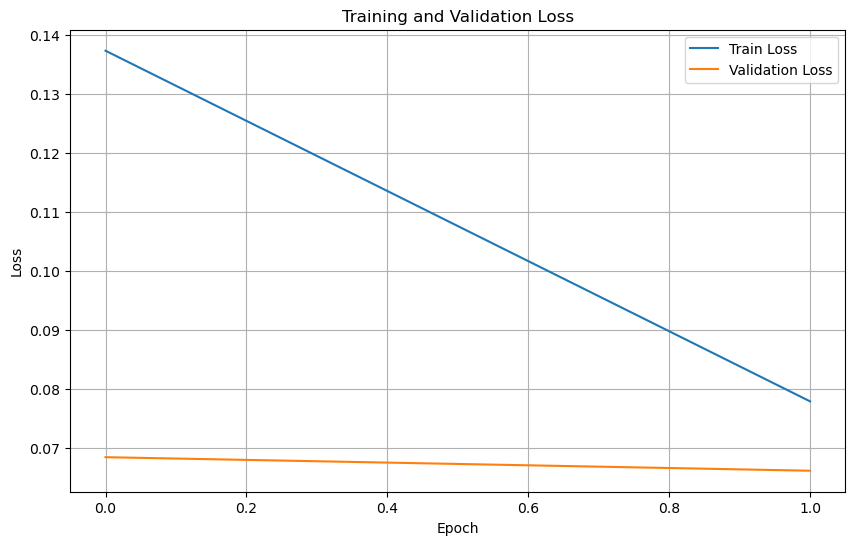

In [ ]:
# Affichage des pertes
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Test

In [ ]:
# Fonction pour calculer la précision, le rappel, le F1-score, l'exactitude et la matrice de confusion
def calculate_metrics(binary_scores, binary_labels):
    # Déplacer les tensors vers le CPU avant de les convertir en NumPy
    binary_scores_flat = binary_scores.cpu().flatten()
    binary_labels_flat = binary_labels.cpu().flatten()

    # Calcul des métriques
    precision = precision_score(binary_labels_flat, binary_scores_flat)
    recall = recall_score(binary_labels_flat, binary_scores_flat)
    f1 = f1_score(binary_labels_flat, binary_scores_flat)
    accuracy = accuracy_score(binary_labels_flat, binary_scores_flat)

    # Matrice de confusion
    cm = confusion_matrix(binary_labels_flat, binary_scores_flat)

    return precision, recall, f1, accuracy, cm

In [ ]:
def plot_confusion_matrix(confusion_matrix, normalize=False):
    # Si normalisation est activée
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix:")      
    else:
        # Conversion explicite pour s'assurer d'afficher les entiers
        confusion_matrix = confusion_matrix.astype(int)
        print("Confusion Matrix (Integers):")

    print(confusion_matrix)

    plt.figure(figsize=(6, 4))
    # Normalisation de la matrice de confusion si nécessaire
    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    # Affichage de la matrice de confusion avec format ajusté
    sns.heatmap(confusion_matrix, annot=True, fmt='.4f' if normalize else 'g', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['True Negative', 'True Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
def test_epoch(model, test_loader):
    model.eval()  # Passer en mode évaluation
    total_loss = 0
    test_loss = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_accuracy = 0  # Pour l'accuracy
    confusion_matrix_total = torch.zeros(2, 2)  # Confusion matrix for binary classification

    progress_bar = tqdm(test_loader, desc="Testing", unit="batch")
    with torch.no_grad():  # Désactiver les gradients pour la phase de test
        for batch in progress_bar:
            input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]

            span_scores, loss = model(
                input_ids=input_ids,
                attention_masks=attention_masks,
                entity_types=entity_ids,
                spans=spans,
                binary_labels=binary_labels,
                sentence_masks=sentence_masks,
                entity_masks=entity_masks
            )

            total_loss += loss.item()

            # Calcul des autres métriques
            binary_scores = (span_scores >= 0.5).int()  # Convertir les scores en prédictions binaires
            precision, recall, f1, accuracy, cm = calculate_metrics(binary_scores, binary_labels)
            
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            total_accuracy += accuracy  # Ajout de l'accuracy
            confusion_matrix_total += torch.tensor(cm)

            # Mise à jour de la barre de progression
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(test_loader)
    # Moyenne des métriques
    average_precision = total_precision / len(test_loader)
    average_recall = total_recall / len(test_loader)
    average_f1 = total_f1 / len(test_loader)
    average_accuracy = total_accuracy / len(test_loader)  # Moyenne de l'accuracy
    confusion_matrix_total = confusion_matrix_total.numpy()

    return avg_loss, average_precision, average_recall, average_f1, average_accuracy, confusion_matrix_total


In [ ]:
test_loss, test_precision, test_recall, test_f1, test_accuracy, cm = test_epoch(model, test_loader)

Testing: 100%|██████████| 29/29 [01:19<00:00,  2.75s/batch, Batch Loss=0.0866]


Test Loss: 0.0745
Test Precision: 0.2158
Test Recall: 0.1939
Test F1 Score: 0.1957
Test Accuracy: 0.9896
Confusion Matrix (Integers):
[[3645765   18171]
 [  20314    4950]]


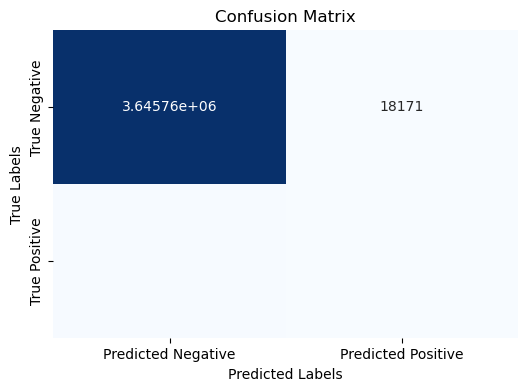

In [ ]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
plot_confusion_matrix(cm,False)

- cm[0, 0] = TN
- cm[0, 1] = FP
- cm[1, 0] = FN
- cm[1, 1] = TP

[[TN,FP]

 [FN,TP]]


# True Test

In [34]:
# Phrase d'exemple
sentence = "Alain Farley, works at McGill University."
entity_types_to_detect = ["person", "organization"]

In [104]:
sentence = "Marie Dupont is a data scientist at OpenAI and she specializes in Python programming."
entity_types_to_detect = ["person", "organization","programming language","job title"]


In [130]:
sentence = "John Smith works at Google and has expertise in machine learning and Java."
entity_types_to_detect = ["person", "organization", "programming language"]

In [178]:
sentence = "Sundar Pichai is the CEO of Google"
entity_types_to_detect = ["person", "organization", "title"]


In [70]:
sentence = "Libretto by Marius Petipa, based on the 1822 novella ``Trilby, ou Le Lutin d'Argail`` by Charles Nodier, first presented by the Ballet of the Moscow Imperial Bolshoi Theatre on January 25/February 6 (Julian/Gregorian calendar dates), 1870, in Moscow with Polina Karpakova as Trilby and Ludiia Geiten as Miranda and restaged by Petipa for the Imperial Ballet at the Imperial Bolshoi Kamenny Theatre on January 17–29, 1871 in St. Petersburg with Adèle Grantzow as Trilby and Lev Ivanov as Count Leopold."
entity_types_to_detect = ["person", "book", "location","date","actor","character"]

In [90]:
sentence = "Feldman is a contributor to NBC Sports Boston's ``State of the Revs`` and ``Revolution Postgame Live`` programs as well as to 98.5 the SportsHub, SiriusXM FC's MLS coverage and to other New England and national radio outlets and podcasts."
entity_types_to_detect = ["person", "company", "location"]

In [35]:
max_entity_per_seq = 10
max_length = 213
max_span_length = 4
threshold_score = 0.5

In [36]:
current_entity_id = []
current_entity_str = []

for entity_type in entity_types_to_detect:
    # Tenter d'ajouter l'entité avec le préfixe [ENT]
    full_entity_token = f"[ENT] {entity_type}"
    full_entity_token_ids = model.tokenizer.convert_tokens_to_ids(full_entity_token)

    # Vérifier si cela retourne un seul ID
    if isinstance(full_entity_token_ids, int):
        # Le token avec [ENT] est valide
        entity_token_id = full_entity_token_ids
    else:
        # Si [ENT] {entity_type} n'est pas reconnu comme un seul token
        entity_token_id = model.tokenizer.convert_tokens_to_ids(entity_type)

        # Vérifier si {entity_type} seul retourne un seul ID
        if isinstance(entity_token_id, list) and len(entity_token_id) > 1:
            # Si cela retourne plusieurs IDs, prendre le premier
            entity_token_id = entity_token_id[0]
        elif isinstance(entity_token_id, list) and len(entity_token_id) == 0:
            # Aucun ID trouvé, entité inconnue
            print(f"Entity '{entity_type}' is not recognized in any form by the tokenizer.")
            continue

    # Ajouter l'ID ou le texte de l'entité s'il est valide
    if entity_token_id not in current_entity_id:
        current_entity_id.append(entity_token_id)
    if entity_type not in current_entity_str:
        current_entity_str.append(entity_type)


entity_tokens = " ".join(f"[ENT] {et}" for et in current_entity_str)

# Tokenisation de la phrase
encoded = model.tokenizer(
    sentence, return_tensors="pt", padding="max_length", truncation=True, add_special_tokens=False
)

# Extraction des IDs et des tokens
input_ids = encoded["input_ids"][0]  # IDs des tokens
sentence_tokens = model.tokenizer.convert_ids_to_tokens(input_ids)

reconstructed_tokens = []
first_subtoken_ids = []
current_word = ""

for i, token in enumerate(sentence_tokens):
    if token.startswith("▁"):  # Début d'un nouveau mot
        if current_word:  # Ajouter le mot courant à la liste reconstruite
            reconstructed_tokens.append(current_word)
        current_word = token[1:]  # Supprimer '▁' pour ce token
        first_subtoken_ids.append(input_ids[i].item())  # ID du premier sous-token
    elif token in string.punctuation:  # Si le token est une ponctuation
        if current_word:  # Ajouter le mot courant avant la ponctuation
            reconstructed_tokens.append(current_word)
            current_word = ""
        reconstructed_tokens.append(token)  # Ajouter la ponctuation comme un token séparé
        first_subtoken_ids.append(input_ids[i].item())  # ID de la ponctuation
    else:  # Sous-token à concaténer
        current_word += token

# Ajouter le dernier mot reconstruit
if current_word:
    reconstructed_tokens.append(current_word)

# Résultats
print("Tokens originaux :", sentence_tokens)
print("Mots reconstruits :", reconstructed_tokens)
print("IDs des premiers sous-tokens :", first_subtoken_ids)
print("Longueur des mots reconstruits :", len(reconstructed_tokens))
print("Longueur des premiers sous-tokens :", len(first_subtoken_ids))


Tokens originaux : ['▁Alain', '▁Farley', ',', '▁works', '▁at', '▁McGill', '▁University', '.']
Mots reconstruits : ['Alain', 'Farley', ',', 'works', 'at', 'McGill', 'University', '.']
IDs des premiers sous-tokens : [39365, 51474, 261, 885, 288, 30235, 689, 260]
Longueur des mots reconstruits : 8
Longueur des premiers sous-tokens : 8


In [37]:
encoded_entity = model.tokenizer(
    entity_tokens, return_tensors="pt", padding="max_length", truncation=True, 
    is_split_into_words=False, add_special_tokens=False
)

encoded_entity = encoded_entity["input_ids"][0].tolist() + [0]*(max_entity_per_seq-len(current_entity_str))

sep_id = model.tokenizer.convert_tokens_to_ids(f'[SEP]')

combined_ids = (
    encoded_entity +
    [sep_id] +
    first_subtoken_ids
)

deleted_ids = max(len(combined_ids) - max_length,0)
combined_ids = combined_ids[:max_length]
combined_ids += [0] * (max_length - len(combined_ids))

# Créer l'attention mask
attention_mask = [1 if id != 0 else 0 for id in combined_ids]

# Masques spécifiques pour les entités et la phrase
entity_mask = [1 if i < len(current_entity_str) else 0 for i in range(len(combined_ids))]
sentence_mask = [1 if i > len(encoded_entity) and combined_ids[i] != 0 and combined_ids[i] != sep_id else 0 
                    for i in range(len(combined_ids))]

current_entity_id = current_entity_id + [0]*(max_entity_per_seq-len(current_entity_str))

# Convertir les entités en un tensor
entity_tensor = torch.tensor(current_entity_id, dtype=torch.long)

# Ajouter les données
input_ids_tensor = torch.tensor(combined_ids, dtype=torch.long)
attention_mask_tensor = torch.tensor(attention_mask, dtype=torch.long)
entity_mask_tensor =torch.tensor(entity_mask, dtype=torch.long)
sentence_mask_tensor = torch.tensor(sentence_mask, dtype=torch.long)

In [38]:
# for batch in test_loader:
#     input_ids, attention_masks, spans, entity_ids, binary_labels, sentence_masks, entity_masks = [b.to(device) for b in batch]
#     input_ids_tensor = input_ids[0]
#     attention_mask_tensor = attention_masks[0]
#     entity_mask_tensor = entity_masks[0]
#     sentence_mask_tensor = sentence_masks[0]
#     entity_tensor = entity_ids[0]
#     binary_labels = binary_labels
#     # Convertir binary_labels[0] en liste et afficher
#     binary_labels_list = binary_labels[0].tolist()  # Conversion en liste
#     print(binary_labels_list)  # Affichage de la liste
#     break


In [39]:
# Conversion des IDs en texte
entity_ids_list = entity_tensor.tolist()  # Convertir le tenseur en liste
entity_types_to_detect_tokens = [
    model.tokenizer.decode([entity_id], skip_special_tokens=False)
    for entity_id in entity_ids_list
    if entity_id != 0
]

# Affichage des résultats
print("Filtered Entity IDs:", [entity_id for entity_id in entity_ids_list if entity_id != 0])
print("Decoded Texts:", entity_types_to_detect_tokens)

# Affichage des résultats
print("Entity IDs:", entity_ids_list)


Filtered Entity IDs: [130845, 129092]
Decoded Texts: ['[ENT] person', '[ENT] organization']
Entity IDs: [130845, 129092, 0, 0, 0, 0, 0, 0, 0, 0]


In [40]:
num_tokens = len(input_ids_tensor) - len(entity_tensor) - 1
spans = [
    (start, end)
    for start in range(num_tokens)
    for end in range(start, min(start + max_span_length, num_tokens))
]

spans_tensor = torch.tensor(spans, dtype=torch.long)

In [41]:
# Passage en mode évaluation
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():  # Pas besoin de calculer les gradients en mode test
    span_scores = model(
        input_ids=input_ids_tensor.unsqueeze(0).to(device),  # Ajout d'une dimension batch
        attention_masks=attention_mask_tensor.unsqueeze(0).to(device),
        entity_types=entity_tensor.unsqueeze(0).to(device),
        spans=spans_tensor.unsqueeze(0).to(device),
        sentence_masks=sentence_mask_tensor.unsqueeze(0).to(device),
        entity_masks=entity_mask_tensor.unsqueeze(0).to(device)
    )

# span_scores contient les scores prédites pour chaque span et chaque entité
print("Span scores:", span_scores)

# Conversion des span scores en valeurs binaires
binary_span_scores = (span_scores > threshold_score).int()

# Affichage des résultats
print("Binary Span Scores:", binary_span_scores)

# Comptage des valeurs 1 dans tout le tenseur
num_ones = binary_span_scores.sum().item()

# Affichage des résultats
print("Nombre de 1:", num_ones)

# Création d'un masque avec des 0 et 1 représentant la valeur la plus élevée dans chaque liste
# Initialisation d'un masque de mêmes dimensions que span_scores
max_mask = torch.zeros_like(span_scores, dtype=torch.int)

# Parcourir chaque batch, span et entité pour identifier les indices des max
for i in range(span_scores.size(1)):  # Dimension des spans
    for j in range(span_scores.size(2)):  # Dimension des entités
        # Trouver l'indice de la valeur maximale dans la liste
        max_index = torch.argmax(span_scores[0, i, :])  # Corrigé pour les dimensions
        # Définir 1 à cet indice dans le masque
        max_mask[0, i, max_index] = 1  # Corrigé pour les dimensions

# Appliquer le masque sur binary_span_scores
masked_binary_span_scores = binary_span_scores * max_mask

# Affichage des résultats
print("Masked Binary Span Scores:", masked_binary_span_scores)


# Affichage des résultats
print("Masked Binary Span Scores:", masked_binary_span_scores)



Span scores: tensor([[[5.4250e-01, 4.8833e-01, 1.3531e-05,  ..., 1.3531e-05,
          1.3531e-05, 1.3531e-05],
         [5.9098e-01, 5.1612e-01, 1.1830e-05,  ..., 1.1830e-05,
          1.1830e-05, 1.1830e-05],
         [1.9620e-02, 2.1016e-02, 4.1630e-07,  ..., 4.1630e-07,
          4.1630e-07, 4.1630e-07],
         ...,
         [2.9213e-06, 7.0306e-06, 1.0796e-14,  ..., 1.0796e-14,
          1.0796e-14, 1.0796e-14],
         [2.9213e-06, 7.0306e-06, 1.0796e-14,  ..., 1.0796e-14,
          1.0796e-14, 1.0796e-14],
         [2.9213e-06, 7.0306e-06, 1.0796e-14,  ..., 1.0796e-14,
          1.0796e-14, 1.0796e-14]]], device='cuda:0')
Binary Span Scores: tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], device='cuda:0', dtype=torch.int32)
Nombre de 1: 10
Masked Binary Span Scores: tensor([[[1, 0, 0,  ..., 0, 0, 0],


In [42]:
# # Convertir les tenseurs en numpy
# binary_scores_np = binary_span_scores[0].cpu().numpy()
# binary_labels_np = binary_labels[0].cpu().numpy()

# # Aplatir les matrices pour les rendre 1D
# y_pred = binary_scores_np.flatten()  # Prédictions
# y_true = binary_labels_np.flatten()  # Labels réels

# # Calculer la matrice de confusion
# conf_matrix = confusion_matrix(y_true, y_pred)

# # Afficher la matrice de confusion
# print("Confusion Matrix:")
# print(conf_matrix)

In [43]:
# Conversion en liste pour un affichage plus lisible
binary_span_scores_list = masked_binary_span_scores.cpu().numpy().tolist()

# Affichage structuré avec les spans associés
print("Binary Span Scores with Spans:")
for i, example in enumerate(binary_span_scores_list):  # Pour chaque exemple dans le batch
    print(f"Example {i + 1}:")
    
    # Création d'une structure tabulaire
    table_data = []
    for j, span_scores in enumerate(example):  # Pour chaque span dans l'exemple
        associated_span = spans[j]  # Associer le span avec l'indice
        # Ajout des données du span et des scores associés
        table_data.append([associated_span] + span_scores[:len(entity_types_to_detect)])
    
    # Création d'un DataFrame pour une meilleure lisibilité
    columns = ["Span"] + entity_types_to_detect  # Colonnes : Span + types d'entités
    df = pd.DataFrame(table_data, columns=columns)
    print(df.to_string(index=False))  # Affichage sans l'index



Binary Span Scores with Spans:
Example 1:
      Span  person  organization
    (0, 0)       1             0
    (0, 1)       1             0
    (0, 2)       0             0
    (0, 3)       0             0
    (1, 1)       1             0
    (1, 2)       0             0
    (1, 3)       0             0
    (1, 4)       0             0
    (2, 2)       0             0
    (2, 3)       0             0
    (2, 4)       0             0
    (2, 5)       0             0
    (3, 3)       0             0
    (3, 4)       0             0
    (3, 5)       0             0
    (3, 6)       0             0
    (4, 4)       0             0
    (4, 5)       0             0
    (4, 6)       0             0
    (4, 7)       0             0
    (5, 5)       1             0
    (5, 6)       1             0
    (5, 7)       0             0
    (5, 8)       0             0
    (6, 6)       1             0
    (6, 7)       0             0
    (6, 8)       0             0
    (6, 9)       0             0
 

In [44]:
# Longueur limite
max_index = len(first_subtoken_ids)

# Filtrage et affichage des résultats
for i, example in enumerate(binary_span_scores_list):
    print(f"Example {i + 1}:")
    
    # Création d'une structure tabulaire
    table_data = []
    for j, span_scores in enumerate(example):
        associated_span = spans[j]
        if associated_span[0] < max_index and associated_span[1] < max_index:  # Condition de filtre
            table_data.append([associated_span] + span_scores[:len(entity_types_to_detect)])
    
    # Création du DataFrame
    columns = ["Span"] + entity_types_to_detect
    df = pd.DataFrame(table_data, columns=columns)
    print(df.to_string(index=False))

Example 1:
  Span  person  organization
(0, 0)       1             0
(0, 1)       1             0
(0, 2)       0             0
(0, 3)       0             0
(1, 1)       1             0
(1, 2)       0             0
(1, 3)       0             0
(1, 4)       0             0
(2, 2)       0             0
(2, 3)       0             0
(2, 4)       0             0
(2, 5)       0             0
(3, 3)       0             0
(3, 4)       0             0
(3, 5)       0             0
(3, 6)       0             0
(4, 4)       0             0
(4, 5)       0             0
(4, 6)       0             0
(4, 7)       0             0
(5, 5)       1             0
(5, 6)       1             0
(5, 7)       0             0
(6, 6)       1             0
(6, 7)       0             0
(7, 7)       0             0


In [45]:
spans_result = []

for i, example in enumerate(binary_span_scores_list):
    print(f"Example {i + 1}:")
    
    for j, span_scores in enumerate(example):
        associated_span = spans[j]
        if associated_span[0] < max_index and associated_span[1] < max_index:  # Condition de filtre
            # Identifier les types d'entité détectés (scores de 1)
            for k, score in enumerate(span_scores[:len(entity_types_to_detect)]):
                if score == 1:  # Entité détectée
                    spans_result.append((associated_span, entity_types_to_detect[k]))

# Affichage du résultat final
print("Spans avec entités détectées :")
for span, entity_type in spans_result:
    print(f"{span} -> {entity_type}")


Example 1:
Spans avec entités détectées :
(0, 0) -> person
(0, 1) -> person
(1, 1) -> person
(5, 5) -> person
(5, 6) -> person
(6, 6) -> person


In [46]:
sentence_output_list = []
sentence_output_str = ""
for index,t in enumerate(reconstructed_tokens):
    span_detected = False
    for span, entity_type in spans_result:
        if(span[0] == index):
            sentence_output_list.append([reconstructed_tokens[span[0]:span[1]+1]] + [entity_type])
            sentence_output_str += '{'
            for w in reconstructed_tokens[span[0]:span[1]+1]:
                sentence_output_str += w + ' '
            sentence_output_str = sentence_output_str[:-1]
            sentence_output_str += '} '
            sentence_output_str += '['+entity_type+'] '

            span_detected = True
    if not span_detected:
        sentence_output_list.append([t])
        sentence_output_str += t+' '
print(sentence_output_list)
print(sentence_output_str)

[[['Alain'], 'person'], [['Alain', 'Farley'], 'person'], [['Farley'], 'person'], [','], ['works'], ['at'], [['McGill'], 'person'], [['McGill', 'University'], 'person'], [['University'], 'person'], ['.']]
{Alain} [person] {Alain Farley} [person] {Farley} [person] , works at {McGill} [person] {McGill University} [person] {University} [person] . 
